# NB-AK8: Plots of Runoff, ET, Precipt over three 30yr period for each GCM from two RCPs

## module loading...

In [1]:
%matplotlib inline  
import os
import sys
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from timeit import default_timer as timer

print("\nThe Python version: %s.%s.%s" % sys.version_info[:3])
print(xr.__name__, xr.__version__)
print(pd.__name__, pd.__version__)

mpl.rcParams['xtick.labelsize']='small'


The Python version: 3.7.0
xarray 0.16.2
pandas 1.2.1


In [2]:
from cmip5_oconus import print_date
print_date()

from cmip5_oconus.data_catalog import load_cmip5_dataset, resample_data
from cmip5_oconus.data_catalog import CMIP5_VIC_MON_ROOT_DIR
from cmip5_oconus.plot import custom_div_cmap, MidpointNormalize

Last executed: 2021-05-08 17:51:30.535778 by mizukami on r6i1n5


In [ ]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster(processes=9, threads=4, memory="108GB",
                  walltime='00:40:00')
cluster.scale(jobs=3)

#from dask_jobqueue import SLURMCluster
#cluster = SLURMCluster()
#cluster.scale(jobs=5)

In [ ]:
from dask.distributed import Client
client = Client(cluster)

In [ ]:
client

-------------------------
## Setup 

In [3]:
figSave = False

In [4]:
gcms = ["ACCESS1-3","CanESM2","CCSM4","CSIRO-Mk3-6-0","GFDL-ESM2M","HadGEM2-ES","inmcm4","MIROC5","MPI-ESM-MR","MRI-CGCM3"]
period_hist = slice('1970-01-01', '1999-12-31')
period_20yr_hist = slice('1980-01-01', '1999-12-31')
hydro_flux_vars= ['PRCP','EVAP', 'total_runoff']

## Load the data

In [5]:
xr.set_options(file_cache_maxsize=12000)
histo_data = {'rcp45': load_cmip5_dataset(root=CMIP5_VIC_MON_ROOT_DIR['grid']['AK'], models=gcms, variables=hydro_flux_vars, scen='hist_rcp45', parallel=False),
              'rcp85': load_cmip5_dataset(root=CMIP5_VIC_MON_ROOT_DIR['grid']['AK'], models=gcms, variables=hydro_flux_vars, scen='hist', parallel=False)}

load_cmip5_dataset


100%|██████████| 10/10 [00:26<00:00,  2.67s/it]

load_cmip5_dataset



100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


## 30 year annual mean

In [37]:
histo_hydro_means = {}
for rcp in ['rcp45', 'rcp85']:
    histo_data[rcp]['total_runoff'] = histo_data[rcp]['BASEFLOW'] + histo_data[rcp]['RUNOFF']
    histo_hydro_means[rcp] = resample_data(histo_data[rcp].sel(time=period_hist), region='AK', freq='AS').persist().mean('time')

In [38]:
diff_hist_hydro_means = histo_hydro_means['rcp45'] -histo_hydro_means['rcp85']

### Plot

In [17]:
# create colormap
# ---------------

from matplotlib.colors import LinearSegmentedColormap

# create a colormap that consists of
# - 1/5 : custom colormap, ranging from white to the first color of the colormap
# - 4/5 : existing colormap

# set upper part: 4 * 256/4 entries
upper = mpl.cm.Spectral_r(np.arange(256))

# set lower part: 1 * 256/4 entries
# - initialize all entries to 1 to make sure that the alpha channel (4th column) is 1
lower = np.ones((int(256/4),4))
# - modify the first three columns (RGB):
#   range linearly between white (1,1,1) and the first color of the upper colormap
for i in range(3):
    lower[:,i] = np.linspace(0.9, upper[0,i], lower.shape[0])

# combine parts of colormap
cmap = np.vstack(( lower, upper ))

# convert to matplotlib colormap
cmap = mpl.colors.ListedColormap(cmap, name='myColorMap', N=cmap.shape[0])

cmap_diff = LinearSegmentedColormap.from_list('custom blue', 
                                             [(0,    'xkcd:red'),
                                              (0.50, 'xkcd:light grey'),
                                              (1,    'xkcd:blue')], N=256)

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizuka

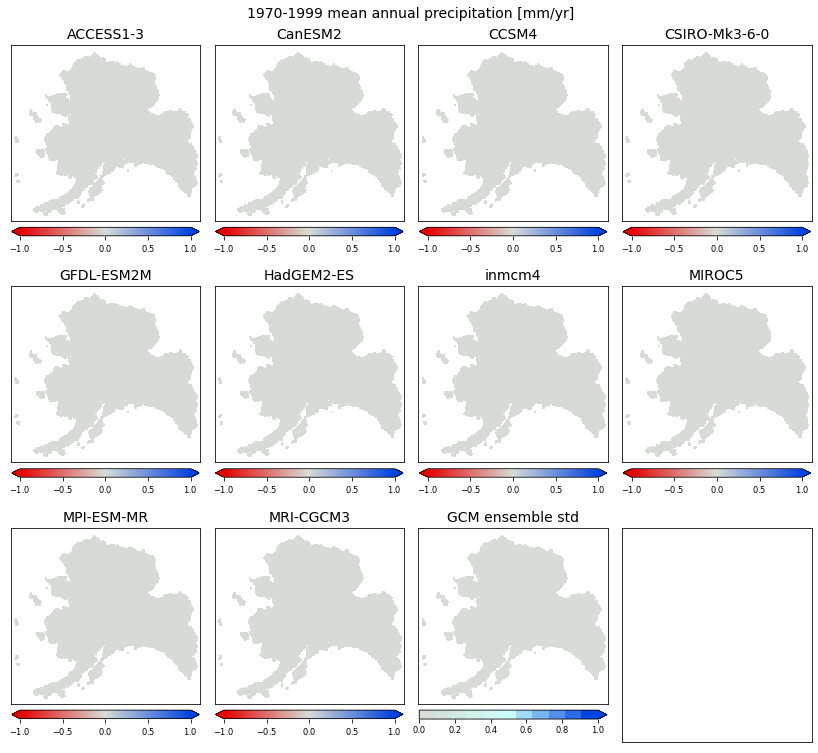

In [28]:
var="PRCP"

cm = {'mean': cmap_diff,
      'std' : custom_div_cmap(mincol='xkcd:light grey', midcol='xkcd:light light blue', maxcol='xkcd:blue')}

#sfmt = mpl.ticker.ScalarFormatter(useMathText=True)
#sfmt.set_powerlimits((0, 0))

cbar_kwrgs = {'mean':   {"orientation":"horizontal", "shrink":0.990, "pad":0.03, 'format':sfmt},
              'std':    {"orientation":"horizontal", "shrink":0.990, "pad":0.03}}

style_kwargs = {'mean': {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['mean']},
                'std':  {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['std']}}

kwargs = {'mean': {'vmin':-1, 'vmax':1, 'cmap':cm['mean'], 'extend':'both', **style_kwargs['mean']},  
          'std':  {'vmin':0, 'vmax':1,  'cmap':cm['std'],  'extend':'max', **style_kwargs['std']}}

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(11.375, 10.5)) # used to be figsize=(14,11)
plt.subplots_adjust(left=0.012, bottom=0.0125, right=0.99, top=0.935, hspace=0.125, wspace=0.075)

for ix, gcm in enumerate(gcms+['GCM ensemble std']):
    row = ix // 4
    col = ix % 4
    if ix < 10:
        diff_hist_hydro_means[var].sel(gcm=gcm).plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 10:
        diff_hist_hydro_means.std(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['std'])
    axes[row, col].set_title(gcm, fontsize=14)
    
#plt.tight_layout()
fig.suptitle('1970-1999 mean annual precipitation [mm/yr]', fontsize=14, y=0.985)
if figSave:
    plt.savefig(f'NB-AK8_Fig1_annual_mean_{var}_hist_rcp45_vs_rcp85.png', dpi=300)

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizuka

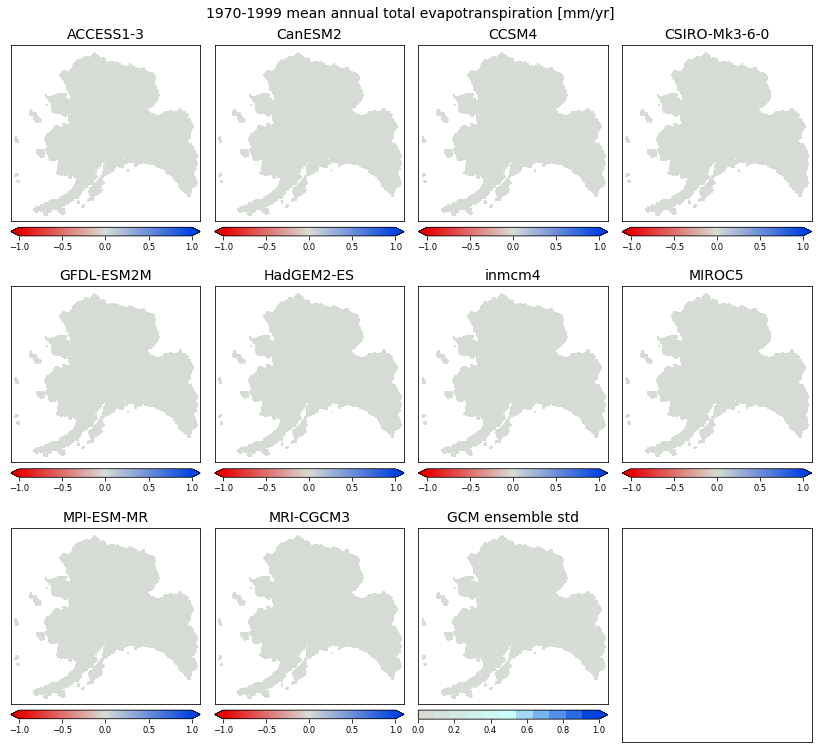

In [32]:
var="EVAP"

cm = {'mean': cmap_diff,
      'std' : custom_div_cmap(mincol='xkcd:light grey', midcol='xkcd:light light blue', maxcol='xkcd:blue')}

style_kwargs =  {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': dict(orientation="horizontal", pad=0.03)}
kwargs = {'mean': {'vmin':-1, 'vmax':1, 'cmap':cm['mean'], 'extend':'both', **style_kwargs},
          'std':  {'vmin':0, 'vmax':1,  'cmap':cm['std'],  'extend':'max', **style_kwargs}}

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(11.375, 10.5)) # used to be figsize=(14,11)
plt.subplots_adjust(left=0.012, bottom=0.0125, right=0.99, top=0.935, hspace=0.125, wspace=0.075)

for ix, gcm in enumerate(gcms+['GCM ensemble std']):
    row = ix // 4
    col = ix % 4
    if ix < 10:
        diff_hist_hydro_means[var].sel(gcm=gcm).plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 10:
        diff_hist_hydro_means.std(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['std'])
    axes[row, col].set_title(gcm, fontsize=14)

fig.suptitle('1970-1999 mean annual total evapotranspiration [mm/yr]', fontsize=14, y=0.985)
if figSave:
    plt.savefig(f'NB-AK8_Fig2_annual_mean_{var}_hist_rcp45_vs_rcp85.png', dpi=300)

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizuka

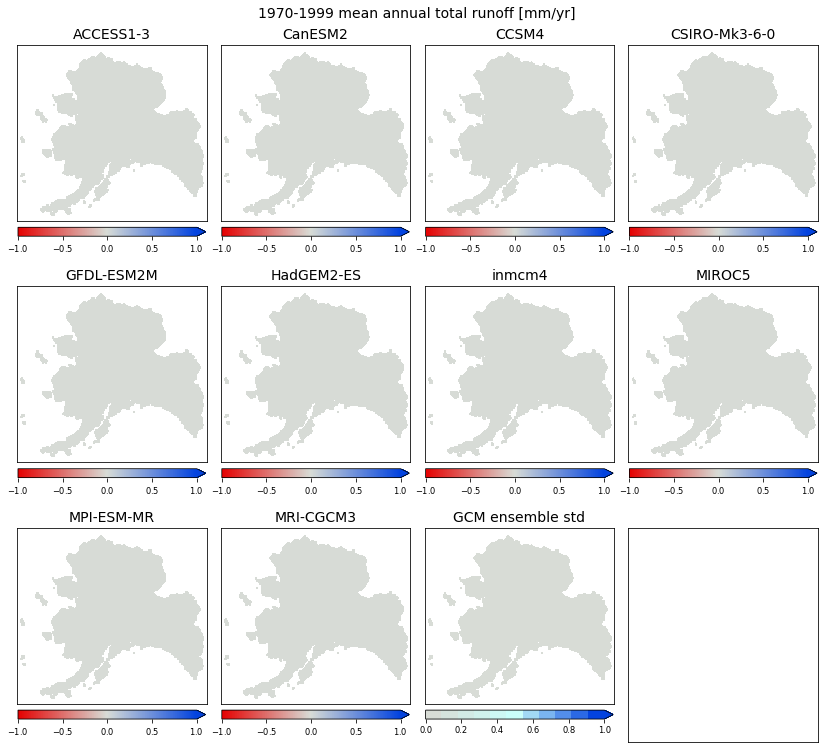

In [39]:
var="total_runoff"

cm = {'mean': cmap_diff,
      'std' : custom_div_cmap(mincol='xkcd:light grey', midcol='xkcd:light light blue', maxcol='xkcd:blue')}

sfmt = mpl.ticker.ScalarFormatter(useMathText=True)
sfmt.set_powerlimits((0, 0))

cbar_kwrgs = {'mean':   {"orientation":"horizontal", "shrink":0.990, "pad":0.03, 'format':sfmt},
              'std':    {"orientation":"horizontal", "shrink":0.990, "pad":0.03}}

style_kwargs = {'mean': {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['mean']},
                'std':  {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['std']}}

kwargs = {'mean': {'vmin':-1, 'vmax':1, 'cmap':cm['mean'], 'extend':'max', **style_kwargs['mean']},
          'std':  {'vmin':0, 'vmax':1,  'cmap':cm['std'],  'extend':'max', **style_kwargs['std']}}

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(11.375, 10.5)) # used to be figsize=(14,11)
plt.subplots_adjust(left=0.012, bottom=0.0125, right=0.99, top=0.935, hspace=0.125, wspace=0.075)

for ix, gcm in enumerate(gcms+['GCM ensemble std']):
    row = ix // 4
    col = ix % 4
    if ix < 10:
        diff_hist_hydro_means[var].sel(gcm=gcm).plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 10:
        diff_hist_hydro_means.std(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['std'])
    axes[row, col].set_title(gcm, fontsize=14)
    
fig.suptitle('1970-1999 mean annual total runoff [mm/yr]', fontsize=14, y=0.985)
if figSave:
    plt.savefig(f'NB-AK8_Fig3_annual_mean_{var}_hist_rcp45_vs_rcp85.png', dpi=300)